In [1]:
# data path align
import numpy as np
from sklearn import preprocessing
import pandas as pd

data_dir = '/root/Competitions/MICCAI/AutoPET2023/data/train'
meta_df = pd.read_csv('/root/Competitions/MICCAI/AutoPET2023/data/Metadata-FDG_PET_CT.csv')
meta_df = meta_df[meta_df['SOP Class Name'] == 'Segmentation Storage'] # to remove the redundancy path
file_paths = meta_df['File Location'].apply(lambda x: '/'.join([data_dir] + x.split('/')[2:4])) # Even faster 


df = pd.DataFrame(columns=['img_path', 'diagnosis'])
df['img_path'] = file_paths
df['diagnosis'] = meta_df.diagnosis
print(f'Type of Diagnosis: {np.unique(df.diagnosis)}')
print(f'{pd.concat([df.diagnosis.value_counts(normalize=True), df.diagnosis.value_counts()], axis=1, keys=["%","|x|"])}')

for idx in range(len(meta_df)): assert df.iloc[idx].diagnosis== meta_df.iloc[idx].diagnosis

le = preprocessing.LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])
print(f"{le.classes_=}, trasformed:{np.unique(df.diagnosis)}")

Type of Diagnosis: ['LUNG_CANCER' 'LYMPHOMA' 'MELANOMA' 'NEGATIVE']
                    %  |x|
diagnosis                 
NEGATIVE     0.505917  513
MELANOMA     0.185404  188
LUNG_CANCER  0.165680  168
LYMPHOMA     0.142998  145
le.classes_=array(['LUNG_CANCER', 'LYMPHOMA', 'MELANOMA', 'NEGATIVE'], dtype=object), trasformed:[0 1 2 3]


In [2]:
# MELANOMA viz 
mela_df = df[df.diagnosis ==2]
mela_sample = mela_df.iloc[2].img_path 

ct = f'{mela_sample}/CT.nii.gz'
ctres = f'{mela_sample}/CTres.nii.gz'
pet = f'{mela_sample}/PET.nii.gz'
seg = f'{mela_sample}/SEG.nii.gz'
suv = f'{mela_sample}/SUV.nii.gz'

In [3]:
# from monai.transforms import LoadImage

# I_ct = LoadImage()(ct)
# I_ctres = LoadImage()(ctres)
# I_pet  = LoadImage()(pet)
# I_seg = LoadImage()(seg)
# I_suv = LoadImage()(suv)



In [4]:
from monai.transforms import LoadImaged, Orientationd, EnsureTyped, Orientationd,EnsureChannelFirstd, NormalizeIntensityd, ScaleIntensityRangePercentilesD, ScaleIntensityRangePercentiles
import matplotlib.pyplot as plt
import torch 


path_d = {
    'ct':ctres,
    'pet':suv,
    'label': seg
}

data_d = LoadImaged(keys=['ct','pet','label'])(path_d)
print(len(data_d), data_d.keys())
data_d = EnsureChannelFirstd(keys=["ct",'pet', "label"])(data_d)
print(len(data_d), data_d.keys())

# for key, value in data_d.items():
#     # print(key, item.shape)
#     print(key, value[0].shape) 



6 dict_keys(['ct', 'pet', 'label', 'ct_meta_dict', 'pet_meta_dict', 'label_meta_dict'])
6 dict_keys(['ct', 'pet', 'label', 'ct_meta_dict', 'pet_meta_dict', 'label_meta_dict'])


In [5]:
print('EnsureTyped apply test')
print('EnsureTyped apply test')
print('EnsureTyped apply test')
print('EnsureTyped apply test')
print()
print('Before')
ct = data_d['ct']
pet = data_d['pet']
print('After')
print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
print(f'\t{data_d["label"].shape=}, {torch.unique(data_d["label"])=}')
data_d = EnsureTyped(keys=['ct','pet','label'])(data_d)
ct = data_d['ct']
pet = data_d['pet']
print('After')
print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
print(f'\t{data_d["label"].shape=}, {torch.unique(data_d["label"])=}')


EnsureTyped apply test
EnsureTyped apply test
EnsureTyped apply test
EnsureTyped apply test

Before
After
	CT  min/max || min:tensor(-1441.7952), max:tensor(3552.0249)
	PEt min/max || min:tensor(0.), max:tensor(74.0492)
	ct.shape=torch.Size([1, 400, 400, 326]), torch.mean(ct)=tensor(-912.4996), torch.unique(ct)=tensor([-1441.7952, -1440.0214, -1397.6876,  ...,  3398.6746,  3447.0364,
         3552.0249])
	pet.shape=torch.Size([1, 400, 400, 326]), torch.mean(pet)=tensor(0.1065), torch.unique(pet)=tensor([0.0000e+00, 4.0440e-05, 4.3189e-05,  ..., 6.1296e+01, 7.1941e+01,
        7.4049e+01])
	data_d["label"].shape=torch.Size([1, 400, 400, 326]), torch.unique(data_d["label"])=tensor([0., 1.])
After
	CT  min/max || min:tensor(-1441.7952), max:tensor(3552.0249)
	PEt min/max || min:tensor(0.), max:tensor(74.0492)
	ct.shape=torch.Size([1, 400, 400, 326]), torch.mean(ct)=tensor(-912.4996), torch.unique(ct)=tensor([-1441.7952, -1440.0214, -1397.6876,  ...,  3398.6746,  3447.0364,
         3552.0

In [6]:
print('Orientationd apply test')
print('Orientationd apply test')
print('Orientationd apply test')
print('Orientationd apply test')
print()
print('Before')
ct = data_d['ct']
pet = data_d['pet']
print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
print(f'\t{data_d["label"].shape=}, {torch.unique(data_d["label"])=}')
data_d = Orientationd(keys=['ct','pet','label'], axcodes="RAS")(data_d)
ct = data_d['ct']
pet = data_d['pet']
print('After')
print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
print(f'\t{data_d["label"].shape=}, {torch.unique(data_d["label"])=}')


Orientationd apply test
Orientationd apply test
Orientationd apply test
Orientationd apply test

Before
	CT  min/max || min:tensor(-1441.7952), max:tensor(3552.0249)
	PEt min/max || min:tensor(0.), max:tensor(74.0492)
	ct.shape=torch.Size([1, 400, 400, 326]), torch.mean(ct)=tensor(-912.4996), torch.unique(ct)=tensor([-1441.7952, -1440.0214, -1397.6876,  ...,  3398.6746,  3447.0364,
         3552.0249])
	pet.shape=torch.Size([1, 400, 400, 326]), torch.mean(pet)=tensor(0.1065), torch.unique(pet)=tensor([0.0000e+00, 4.0440e-05, 4.3189e-05,  ..., 6.1296e+01, 7.1941e+01,
        7.4049e+01])
	data_d["label"].shape=torch.Size([1, 400, 400, 326]), torch.unique(data_d["label"])=tensor([0., 1.])
After
	CT  min/max || min:tensor(-1441.7952), max:tensor(3552.0249)
	PEt min/max || min:tensor(0.), max:tensor(74.0492)
	ct.shape=torch.Size([1, 400, 400, 326]), torch.mean(ct)=tensor(-912.4995), torch.unique(ct)=tensor([-1441.7952, -1440.0214, -1397.6876,  ...,  3398.6746,  3447.0364,
         3552.024

In [7]:
# print('NormalizeIntensityd apply test')
# print('NormalizeIntensityd apply test')
# print('NormalizeIntensityd apply test')
# print('NormalizeIntensityd apply test')
# print()
# print('before')
# ct = data_d['image'][0] 
# pet = data_d['image'][1]
# print(f'{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
# print(f'{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
# print(f'{data_d["label"].shape=}, {torch.unique(data_d["label"])=}')
# data_d = NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True)(data_d)
# print('After')
# print(f'{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
# print(f'{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
# print(f'{data_d["label"].shape=}, {torch.unique(data_d["label"])=}')

print('ScaleIntensityRangePercentilesD apply test')
print('ScaleIntensityRangePercentilesD apply test')
print('ScaleIntensityRangePercentilesD apply test')
print('ScaleIntensityRangePercentilesD apply test')
print()
print('Before')
ct = data_d['ct']
pet = data_d['pet']
print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
print(f'\t{data_d["label"].shape=}, {torch.unique(data_d["label"])=}')
data_d = ScaleIntensityRangePercentilesD(keys=['ct'],  ## this is for only CTres image 
                                         lower=1, upper=99,
                                         b_min=0, b_max=1,
                                         clip=True)(data_d)
ct = data_d['ct']
pet = data_d['pet']
print('After')
print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
print(f'\t{data_d["label"].shape=}, {torch.unique(data_d["label"])=}')


ScaleIntensityRangePercentilesD apply test
ScaleIntensityRangePercentilesD apply test
ScaleIntensityRangePercentilesD apply test
ScaleIntensityRangePercentilesD apply test

Before
	CT  min/max || min:tensor(-1441.7952), max:tensor(3552.0249)
	PEt min/max || min:tensor(0.), max:tensor(74.0492)
	ct.shape=torch.Size([1, 400, 400, 326]), torch.mean(ct)=tensor(-912.4995), torch.unique(ct)=tensor([-1441.7952, -1440.0214, -1397.6876,  ...,  3398.6746,  3447.0364,
         3552.0249])
	pet.shape=torch.Size([1, 400, 400, 326]), torch.mean(pet)=tensor(0.1065), torch.unique(pet)=tensor([0.0000e+00, 4.0440e-05, 4.3189e-05,  ..., 6.1296e+01, 7.1941e+01,
        7.4049e+01])
	data_d["label"].shape=torch.Size([1, 400, 400, 326]), torch.unique(data_d["label"])=tensor([0., 1.])
After
	CT  min/max || min:tensor(0.), max:tensor(1.)
	PEt min/max || min:tensor(0.), max:tensor(74.0492)
	ct.shape=torch.Size([1, 400, 400, 326]), torch.mean(ct)=tensor(0.0948), torch.unique(ct)=tensor([0.0000e+00, 5.2802e-08, 1

## Spacing:ReSampling 

이거는 이미 맞추어져있기 때문에 할 필요가 없다고 말씀해주심

In [8]:
# from monai.transforms import Spacingd
# print('Spacingd apply test')
# print('Spacingd apply test')
# print('Spacingd apply test')
# print('Spacingd apply test')
# print()
# print('Before')
# ct = data_d['ct']
# pet = data_d['pet']
# label = data_d['label']
# print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
# print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
# print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
# print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
# print(f'\t{label.shape=}, {torch.unique(label)=}')
# data_d = Spacingd(keys=['ct', 'pet','label'], pixdim=[2.5,2.5,2.5], mode=('bilinear','bilinear', 'nearest'))(data_d)
# ct = data_d['ct']
# pet = data_d['pet']
# label = data_d['label']
# print('After')
# print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
# print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
# print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
# print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
# print(f'\t{label.shape=}, {torch.unique(label)=}')

# # ct.shape=torch.Size([1, 814, 814, 760]), torch.mean(ct)=tensor(0.0723), torch.unique(ct)=tensor([0.0000e+00, 5.7396e-26, 9.9844e-26,  ..., 1.0000e+00, 1.0000e+00,
# #         1.0000e+00])
# # 	pet.shape=torch.Size([1, 814, 814, 760]), torch.mean(pet)=tensor(0.0710), torch.unique(pet)=tensor([0.0000e+00, 1.3846e-24, 3.2320e-24,  ..., 2.4338e+01, 2.4696e+01,
# #         2.4804e+01])
# # 	label.shape=torch.Size([1, 814, 814, 760])

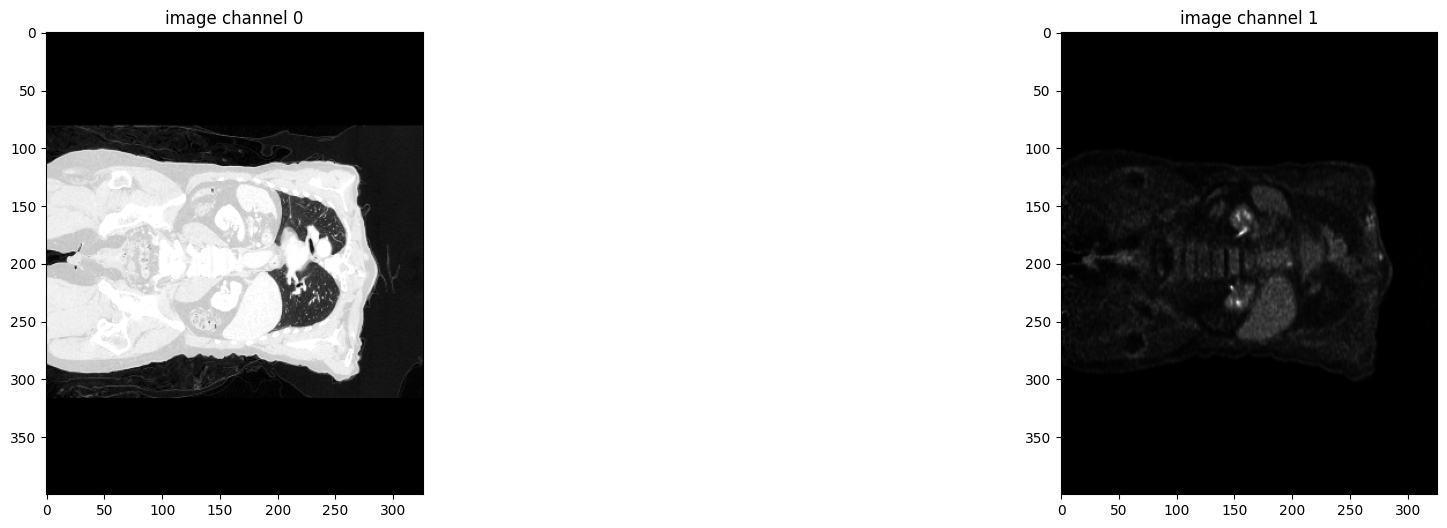

label shape: torch.Size([1, 400, 400, 326])


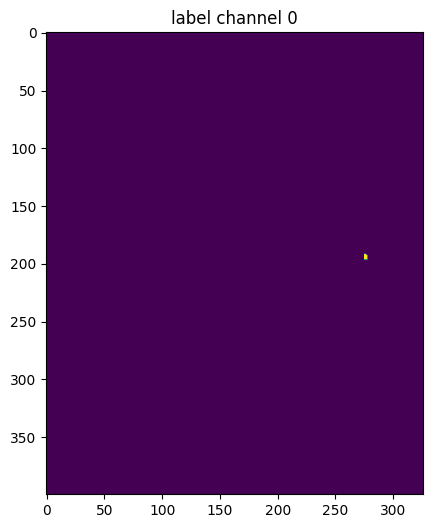

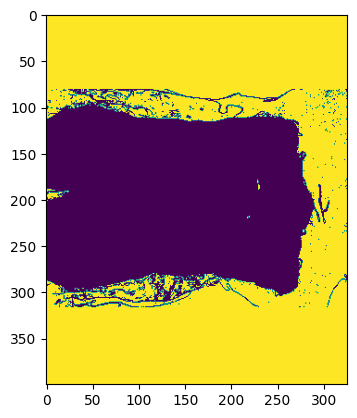

In [9]:
# before applying cropforeground
label = data_d['label']
val_data_example = [ct, pet]
threshed = torch.where(ct < 0.1, 1, 0)
# print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example[i][0, :, 170,:].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {label.shape}")
plt.figure("label", (18, 6))
for i in range(1):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(label[0, :, 170,:].detach().cpu())
plt.show()

plt.imshow(threshed[0, :, 170, :].detach().cpu())


In [10]:
# test 
from monai.transforms import CropForegroundd
concat = torch.concat([ct, pet], dim=0)
print(concat.shape)

data_c = {
    'image':concat,
    'label':label
}

cropped = CropForegroundd(keys=["image","label"], source_key="image")(data_c)
cropped['image'].shape

torch.Size([2, 400, 400, 326])


torch.Size([2, 345, 346, 326])

In [11]:
origin = data_d

In [12]:
# CropForegroundd(keys=all_key, source_key='ct') # source_key 'ct' or 'pet'

from monai.transforms import CropForegroundd
all_key = ['ct','pet','label']
print('CropForegroundd apply test')
print('CropForegroundd apply test')
print('CropForegroundd apply test')
print('CropForegroundd apply test')
print()
print('Before')

ct = data_d['ct']
pet = data_d['pet']
label = data_d['label']
print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
print(f'\t{label.shape=}, {torch.unique(label)=}')
data_d = CropForegroundd(keys=all_key, source_key='ct')(data_d)
ct = data_d['ct']
pet = data_d['pet']
label = data_d['label']
print('After')
print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
print(f'\t{label.shape=}, {torch.unique(label)=}')

# source_key == 'ct'
# After
# 	CT  min/max || min:tensor(0.), max:tensor(1.)
# 	PEt min/max || min:tensor(0.), max:tensor(47.2644)
# 	ct.shape=torch.Size([1, 245, 245, 326]), torch.mean(ct)=tensor(0.2483), torch.unique(ct)=tensor([0.0000e+00, 5.3820e-08, 1.0764e-07,  ..., 1.0000e+00, 1.0000e+00,
#         1.0000e+00])
# 	pet.shape=torch.Size([1, 245, 245, 326]), torch.mean(pet)=tensor(0.2686), torch.unique(pet)=tensor([0.0000e+00, 3.9306e-05, 4.3697e-05,  ..., 4.4398e+01, 4.5633e+01,
#         4.7264e+01])
# 	label.shape=torch.Size([1, 245, 245, 326]), torch.unique(label)=tensor([0., 1.])

# source_key == 'pet'
# After
#   CT  min/max || min:tensor(0.), max:tensor(1.)
# 	PEt min/max || min:tensor(0.), max:tensor(47.2644)
# 	ct.shape=torch.Size([1, 347, 347, 326]), torch.mean(ct)=tensor(0.1238), torch.unique(ct)=tensor([0.0000e+00, 5.3820e-08, 1.0764e-07,  ..., 1.0000e+00, 1.0000e+00,
#         1.0000e+00])
# 	pet.shape=torch.Size([1, 347, 347, 326]), torch.mean(pet)=tensor(0.1341), torch.unique(pet)=tensor([0.0000e+00, 3.9306e-05, 4.3697e-05,  ..., 4.4398e+01, 4.5633e+01,
#         4.7264e+01])
# 	label.shape=torch.Size([1, 347, 347, 326]), torch.unique(label)=tensor([0., 1.])

CropForegroundd apply test
CropForegroundd apply test
CropForegroundd apply test
CropForegroundd apply test

Before
	CT  min/max || min:tensor(0.), max:tensor(1.)
	PEt min/max || min:tensor(0.), max:tensor(74.0492)
	ct.shape=torch.Size([1, 400, 400, 326]), torch.mean(ct)=tensor(0.0948), torch.unique(ct)=tensor([0.0000e+00, 5.2802e-08, 1.0560e-07,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])
	pet.shape=torch.Size([1, 400, 400, 326]), torch.mean(pet)=tensor(0.1065), torch.unique(pet)=tensor([0.0000e+00, 4.0440e-05, 4.3189e-05,  ..., 6.1296e+01, 7.1941e+01,
        7.4049e+01])
	label.shape=torch.Size([1, 400, 400, 326]), torch.unique(label)=tensor([0., 1.])
After
	CT  min/max || min:tensor(0.), max:tensor(1.)
	PEt min/max || min:tensor(0.), max:tensor(74.0492)
	ct.shape=torch.Size([1, 239, 239, 326]), torch.mean(ct)=tensor(0.2655), torch.unique(ct)=tensor([0.0000e+00, 5.2802e-08, 1.0560e-07,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])
	pet.shape=torch.Size([1, 239, 239, 326]

source_key == ct


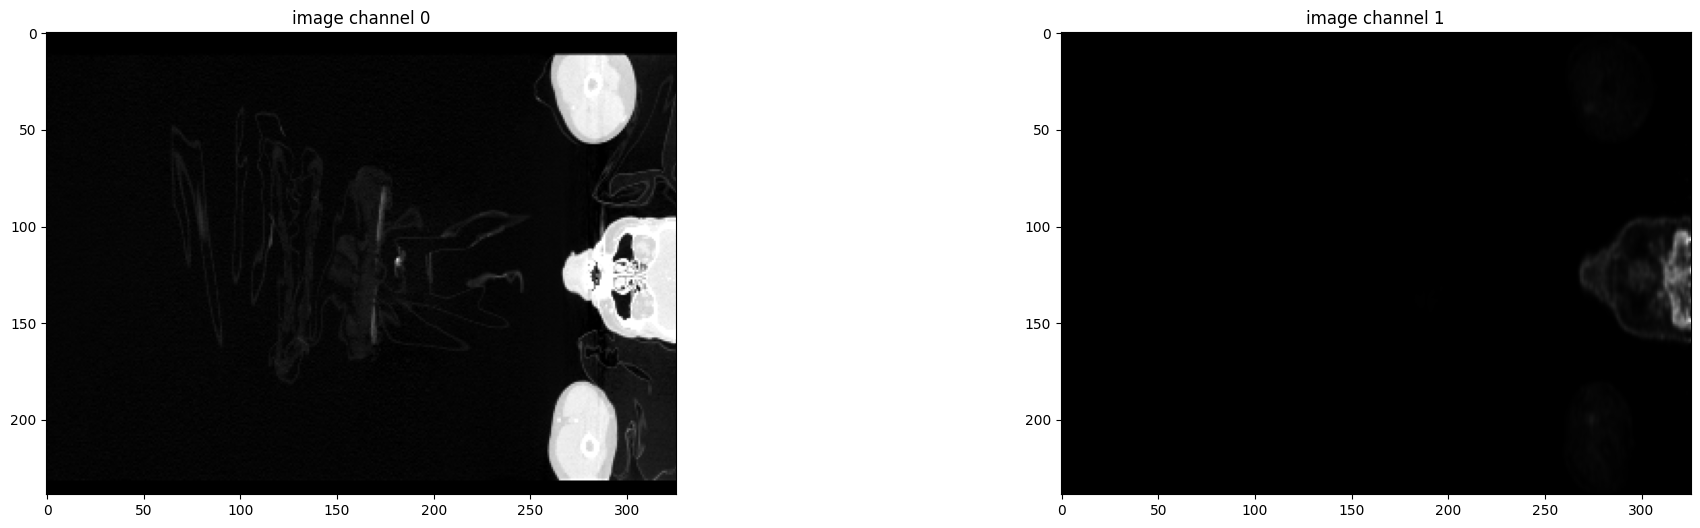

label shape: torch.Size([1, 239, 239, 326])


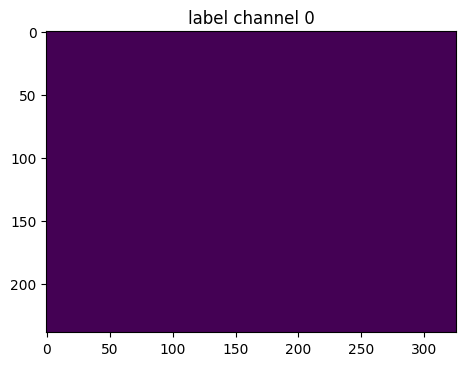

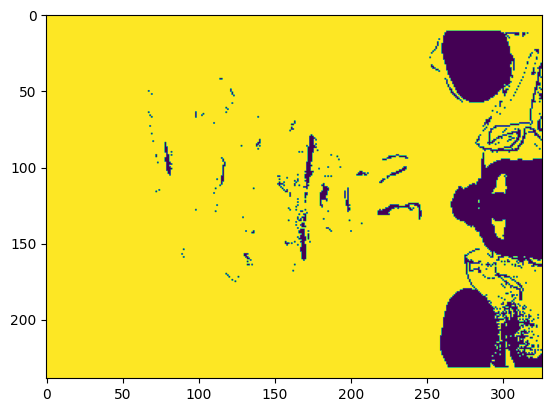

In [13]:
print('source_key == ct')
val_data_example = [ct, pet]
# print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example[i][0, :, 170  ,:].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {label.shape}")
plt.figure("label", (18, 6))
for i in range(1):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(label[0][0:, 170  ,:].detach().cpu())
plt.show()

threshed = torch.where(ct < 0.1, 1, 0)
plt.imshow(threshed[0, :, 170, :].detach().cpu())

In [14]:
data_d = origin

In [15]:
# CropForegroundd(keys=all_key, source_key='ct') # source_key 'ct' or 'pet'

from monai.transforms import CropForegroundd
all_key = ['ct','pet','label']
print('CropForegroundd apply test')
print('CropForegroundd apply test')
print('CropForegroundd apply test')
print('CropForegroundd apply test')
print()
print('Before')

ct = data_d['ct']
pet = data_d['pet']
label = data_d['label']
print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
print(f'\t{label.shape=}, {torch.unique(label)=}')
data_d = CropForegroundd(keys=all_key, source_key='pet')(data_d)
ct = data_d['ct']
pet = data_d['pet']
label = data_d['label']
print('After')
print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
print(f'\t{label.shape=}, {torch.unique(label)=}')

# source_key == 'ct'
# After
# 	CT  min/max || min:tensor(0.), max:tensor(1.)
# 	PEt min/max || min:tensor(0.), max:tensor(47.2644)
# 	ct.shape=torch.Size([1, 245, 245, 326]), torch.mean(ct)=tensor(0.2483), torch.unique(ct)=tensor([0.0000e+00, 5.3820e-08, 1.0764e-07,  ..., 1.0000e+00, 1.0000e+00,
#         1.0000e+00])
# 	pet.shape=torch.Size([1, 245, 245, 326]), torch.mean(pet)=tensor(0.2686), torch.unique(pet)=tensor([0.0000e+00, 3.9306e-05, 4.3697e-05,  ..., 4.4398e+01, 4.5633e+01,
#         4.7264e+01])
# 	label.shape=torch.Size([1, 245, 245, 326]), torch.unique(label)=tensor([0., 1.])

# source_key == 'pet'
# After
#   CT  min/max || min:tensor(0.), max:tensor(1.)
# 	PEt min/max || min:tensor(0.), max:tensor(47.2644)
# 	ct.shape=torch.Size([1, 347, 347, 326]), torch.mean(ct)=tensor(0.1238), torch.unique(ct)=tensor([0.0000e+00, 5.3820e-08, 1.0764e-07,  ..., 1.0000e+00, 1.0000e+00,
#         1.0000e+00])
# 	pet.shape=torch.Size([1, 347, 347, 326]), torch.mean(pet)=tensor(0.1341), torch.unique(pet)=tensor([0.0000e+00, 3.9306e-05, 4.3697e-05,  ..., 4.4398e+01, 4.5633e+01,
#         4.7264e+01])
# 	label.shape=torch.Size([1, 347, 347, 326]), torch.unique(label)=tensor([0., 1.])

CropForegroundd apply test
CropForegroundd apply test
CropForegroundd apply test
CropForegroundd apply test

Before
	CT  min/max || min:tensor(0.), max:tensor(1.)
	PEt min/max || min:tensor(0.), max:tensor(74.0492)
	ct.shape=torch.Size([1, 400, 400, 326]), torch.mean(ct)=tensor(0.0948), torch.unique(ct)=tensor([0.0000e+00, 5.2802e-08, 1.0560e-07,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])
	pet.shape=torch.Size([1, 400, 400, 326]), torch.mean(pet)=tensor(0.1065), torch.unique(pet)=tensor([0.0000e+00, 4.0440e-05, 4.3189e-05,  ..., 6.1296e+01, 7.1941e+01,
        7.4049e+01])
	label.shape=torch.Size([1, 400, 400, 326]), torch.unique(label)=tensor([0., 1.])
After
	CT  min/max || min:tensor(0.), max:tensor(1.)
	PEt min/max || min:tensor(0.), max:tensor(74.0492)
	ct.shape=torch.Size([1, 345, 346, 326]), torch.mean(ct)=tensor(0.1270), torch.unique(ct)=tensor([0.0000e+00, 5.2802e-08, 1.0560e-07,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])
	pet.shape=torch.Size([1, 345, 346, 326]

source_key == pet


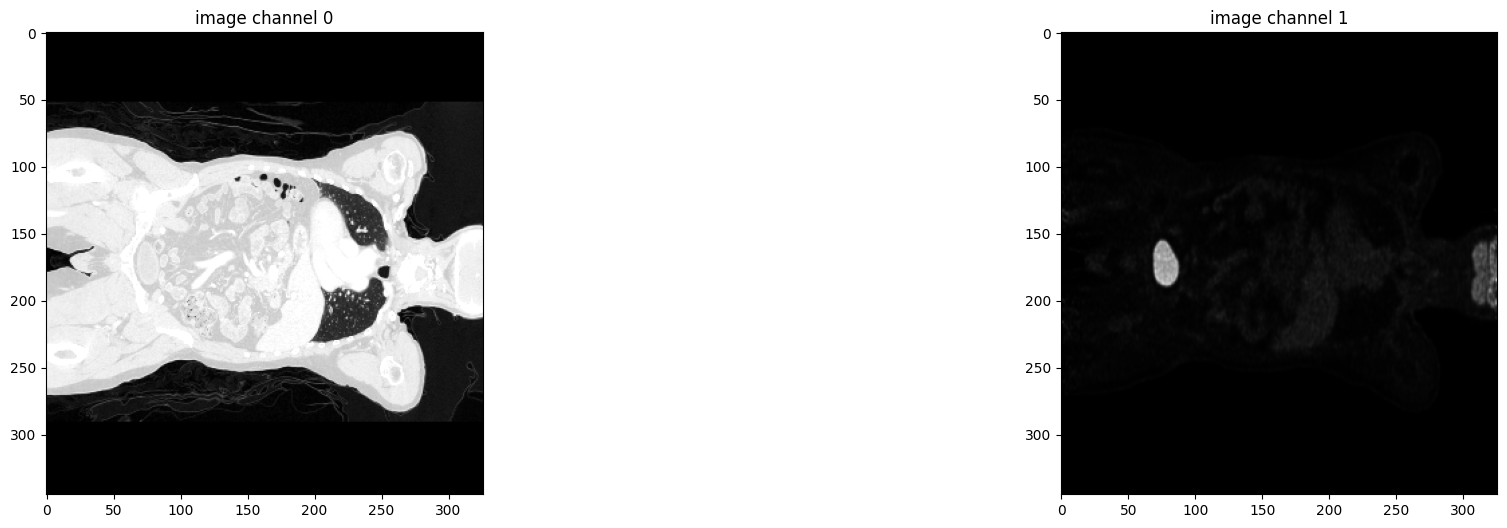

label shape: torch.Size([1, 345, 346, 326])


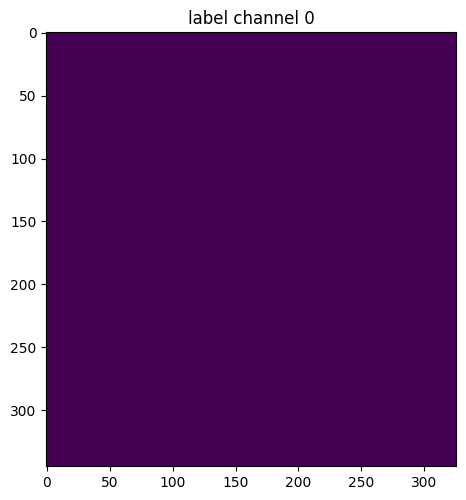

torch.Size([345, 326])


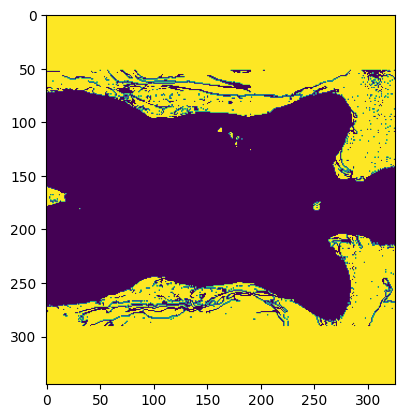

In [16]:
print('source_key == pet')
val_data_example = [ct, pet]
# print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example[i][0, :, 170  ,:].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {label.shape}")
plt.figure("label", (18, 6))
for i in range(1):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(label[0][0:, 170  ,:].detach().cpu())
plt.show()

threshed = torch.where(ct < 0.1, 1, 0)
print(threshed[0, :, 170, :].shape)
plt.imshow(threshed[0, :, 170, :].detach().cpu())


In [17]:
# origin = data_d
data_d = origin

RandCropByPosNegLabeld apply test
RandCropByPosNegLabeld apply test
RandCropByPosNegLabeld apply test
RandCropByPosNegLabeld apply test

Before
	CT  min/max || min:tensor(0.), max:tensor(1.)
	PEt min/max || min:tensor(0.), max:tensor(74.0492)
	ct.shape=torch.Size([1, 400, 400, 326]), torch.mean(ct)=tensor(0.0948), torch.unique(ct)=tensor([0.0000e+00, 5.2802e-08, 1.0560e-07,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])
	pet.shape=torch.Size([1, 400, 400, 326]), torch.mean(pet)=tensor(0.1065), torch.unique(pet)=tensor([0.0000e+00, 4.0440e-05, 4.3189e-05,  ..., 6.1296e+01, 7.1941e+01,
        7.4049e+01])
	label.shape=torch.Size([1, 400, 400, 326]), torch.unique(label)=tensor([0., 1.])
After
	CT  min/max || min:tensor(0.), max:tensor(1.)
	PEt min/max || min:tensor(0.), max:tensor(74.0492)
	ct.shape=torch.Size([1, 400, 400, 326]), torch.mean(ct)=tensor(0.0948), torch.unique(ct)=tensor([0.0000e+00, 5.2802e-08, 1.0560e-07,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])
	pet.shape=t

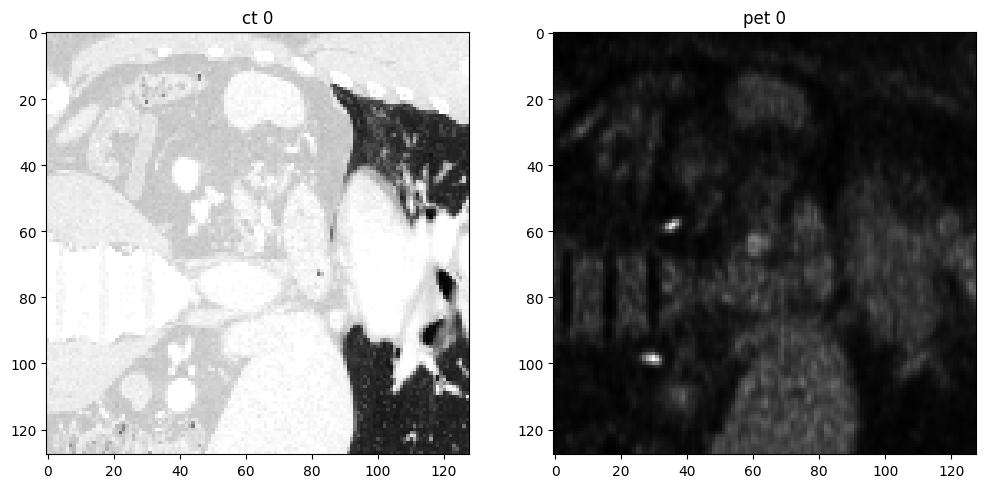

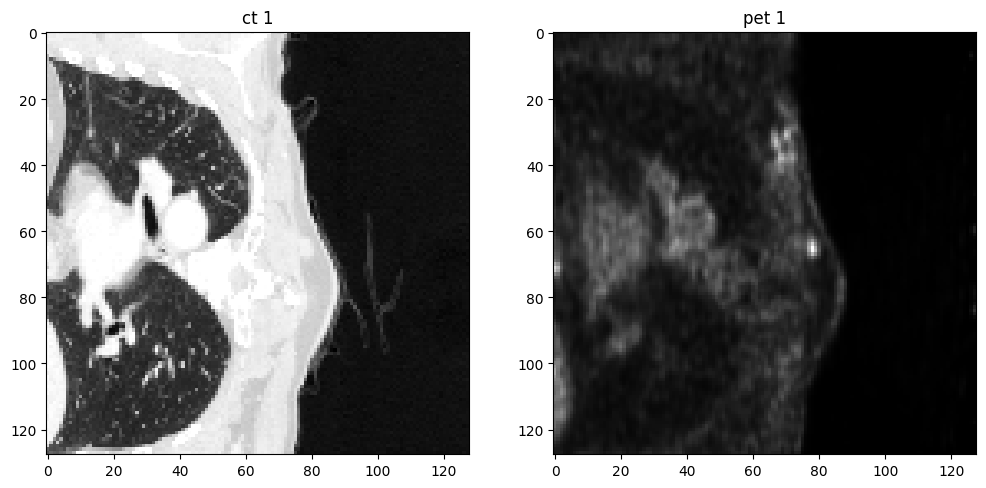

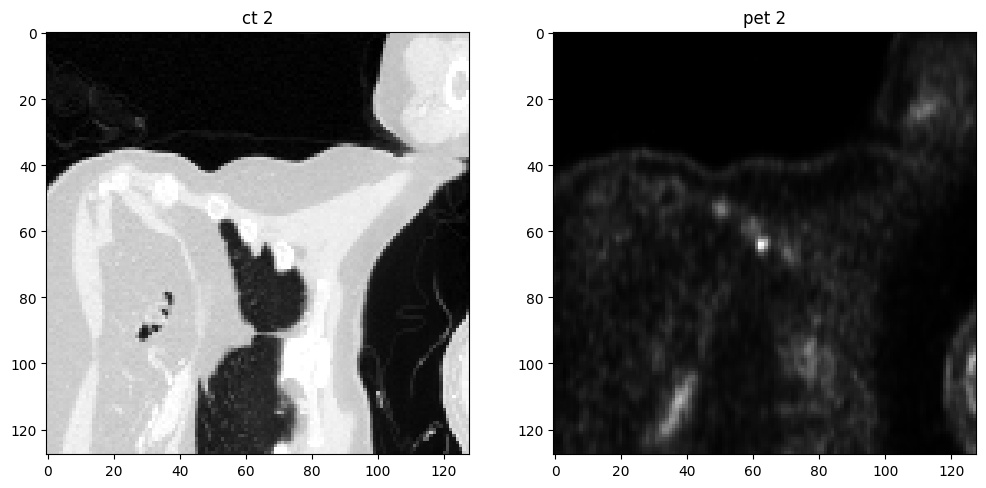

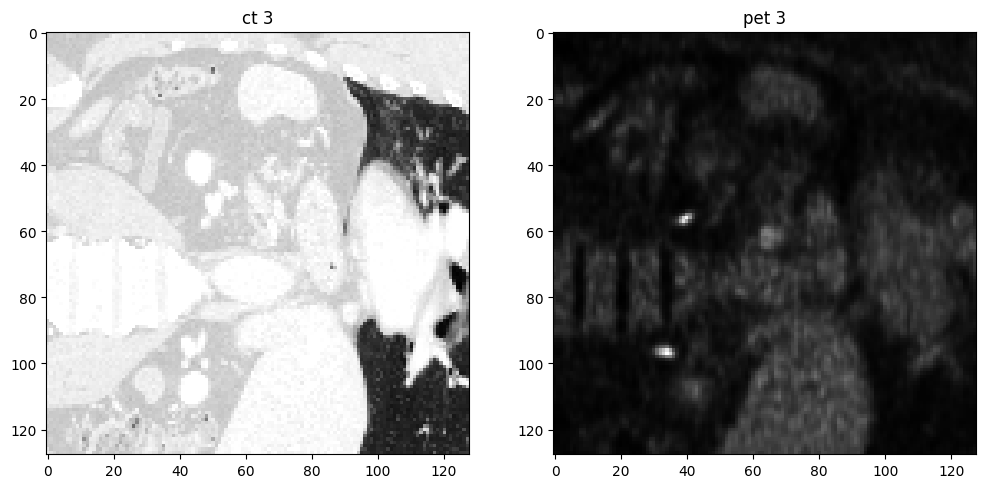

In [18]:
from monai.transforms import RandCropByPosNegLabeld
data_d = origin
all_key = ['ct','pet','label']
print('RandCropByPosNegLabeld apply test')
print('RandCropByPosNegLabeld apply test')
print('RandCropByPosNegLabeld apply test')
print('RandCropByPosNegLabeld apply test')
print()
print('Before')

ct = data_d['ct']
pet = data_d['pet']
label = data_d['label']
print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
print(f'\t{label.shape=}, {torch.unique(label)=}')
data_d = RandCropByPosNegLabeld(keys=all_key, label_key='label', spatial_size=(128,128,128), pos=1, neg=0.5, num_samples=4)(data_d)


print('After')
print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
print(f'\t{label.shape=}, {torch.unique(label)=}')

for i in range(len(data_d)):
    ct = data_d[i]['ct']
    pet = data_d[i]['pet']
    label = data_d[i]['label']
    plt.figure("image", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"ct {i}")
    plt.imshow(ct[0, :, 64  ,:].detach().cpu(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title(f"pet {i}")
    plt.imshow(pet[0, :, 64  ,:].detach().cpu(), cmap="gray")
    plt.show()


RandCropByPosNegLabeld apply test
RandCropByPosNegLabeld apply test
RandCropByPosNegLabeld apply test
RandCropByPosNegLabeld apply test

Before
	CT  min/max || min:tensor(0.), max:tensor(1.)
	PEt min/max || min:tensor(0.), max:tensor(74.0492)
	ct.shape=torch.Size([1, 400, 400, 326]), torch.mean(ct)=tensor(0.0948), torch.unique(ct)=tensor([0.0000e+00, 5.2802e-08, 1.0560e-07,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])
	pet.shape=torch.Size([1, 400, 400, 326]), torch.mean(pet)=tensor(0.1065), torch.unique(pet)=tensor([0.0000e+00, 4.0440e-05, 4.3189e-05,  ..., 6.1296e+01, 7.1941e+01,
        7.4049e+01])
	label.shape=torch.Size([1, 400, 400, 326]), torch.unique(label)=tensor([0., 1.])
After
	CT  min/max || min:tensor(0.), max:tensor(1.)
	PEt min/max || min:tensor(0.), max:tensor(28.2669)
	ct.shape=torch.Size([1, 128, 128, 128]), torch.mean(ct)=tensor(0.1940), torch.unique(ct)=tensor([0.0000e+00, 5.2802e-08, 1.0560e-07,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])
	pet.shape=t

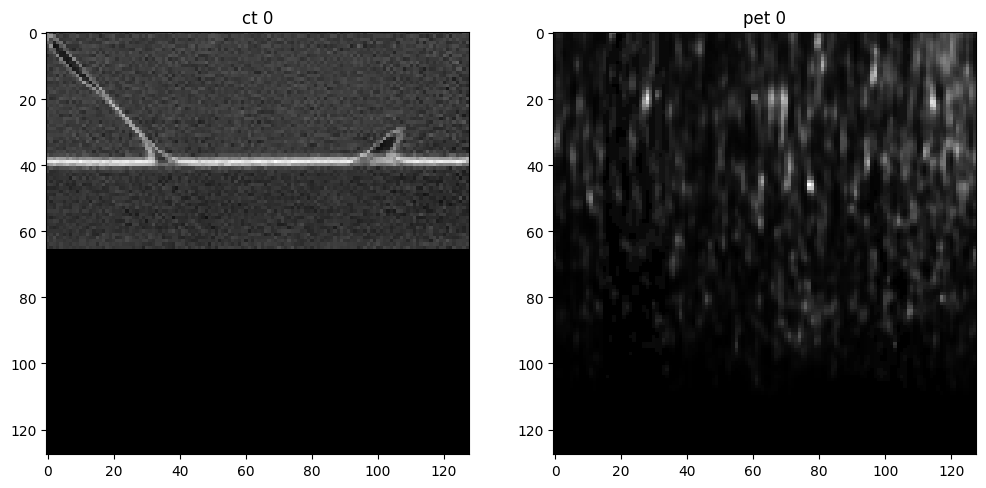

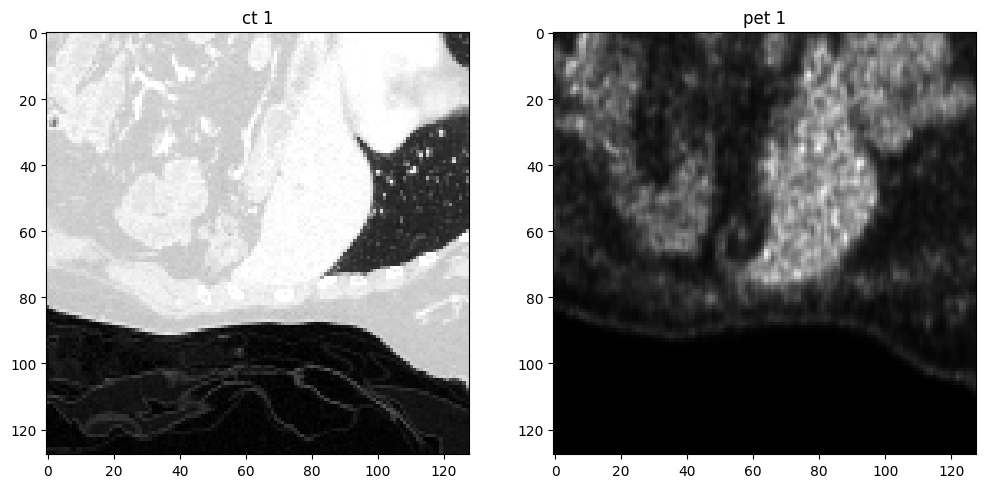

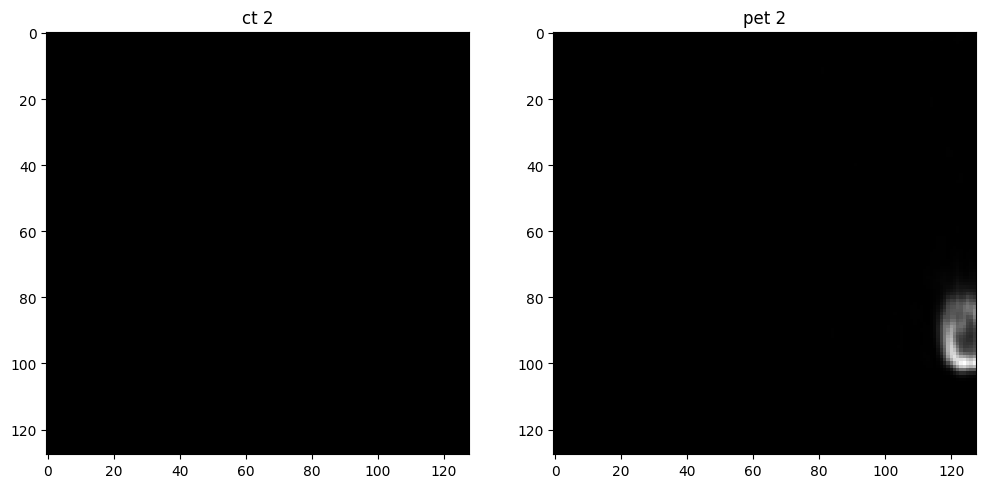

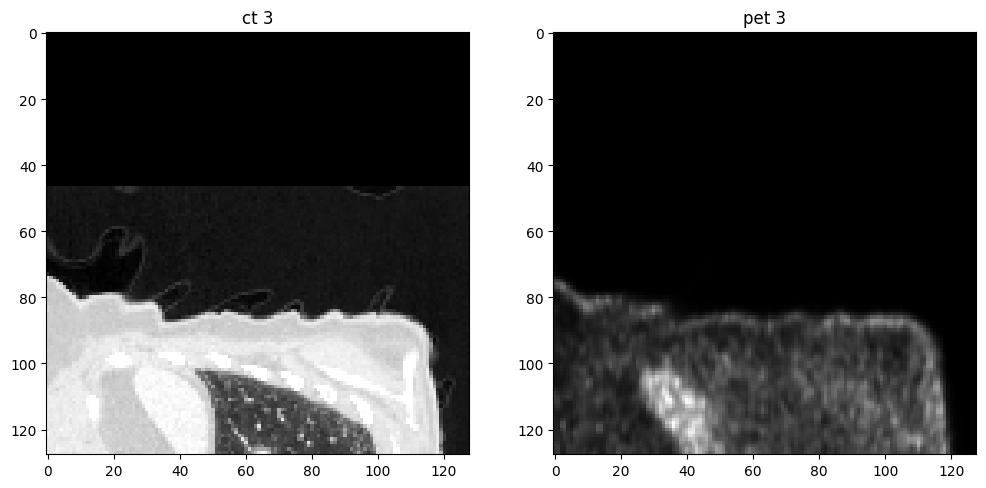

In [19]:
from monai.transforms import RandSpatialCropd
# RandSpatialCropd(keys=["image", "label"], roi_size=[args.img_size,args.img_size,args.img_size], random_size=False),
data_d = origin
all_key = ['ct','pet','label']
print('RandCropByPosNegLabeld apply test')
print('RandCropByPosNegLabeld apply test')
print('RandCropByPosNegLabeld apply test')
print('RandCropByPosNegLabeld apply test')
print()
print('Before')

ct = data_d['ct']
pet = data_d['pet']
label = data_d['label']
print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
print(f'\t{label.shape=}, {torch.unique(label)=}')

for i in range(4):
    cropped = RandSpatialCropd(keys=all_key,roi_size=(128,128,128), random_size=False)(data_d)

    ct = cropped['ct']
    pet = cropped['pet']
    label = cropped['label']
    if not i:
        print('After')
        print(f'\tCT  min/max || min:{torch.min(ct)}, max:{torch.max(ct)}') #tensor(-1346.2589) tensor(3341.4724)
        print(f'\tPEt min/max || min:{torch.min(pet)}, max:{torch.max(pet)}') #tensor(-1346.2589) tensor(3341.4724)
        print(f'\t{ct.shape=}, {torch.mean(ct)=}, {torch.unique(ct)=}')
        print(f'\t{pet.shape=}, {torch.mean(pet)=}, {torch.unique(pet)=}')
        print(f'\t{label.shape=}, {torch.unique(label)=}')

    
    plt.figure("image", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"ct {i}")
    plt.imshow(ct[0, :, 64  ,:].detach().cpu(), cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title(f"pet {i}")
    plt.imshow(pet[0, :, 64  ,:].detach().cpu(), cmap="gray")
    plt.show()


# ancker

In [20]:
from monai.transforms.utils import OneOf

oneof = OneOf(
    [
        RandSpatialCropd(keys=all_key,roi_size=(128,128,128), random_size=False),
        RandCropByPosNegLabeld(keys=all_key, label_key='label', spatial_size=(128,128,128), pos=1, neg=0.5, num_samples=4)
    ]
)

In [21]:
from monai.transforms import LoadImage
from tqdm import tqdm


# MELANOMA viz 
mela_df = df[df.diagnosis ==2]
paths = mela_df.img_path.apply(lambda x: '/'.join([x] + ['CTres.nii.gz'] )).values

print(len(paths))


188


# for validation Check (plotting + manual monitoring)


In [67]:
from monai.transforms import LoadImage
from tqdm import tqdm


# MELANOMA viz 
mela_df = df
paths = mela_df.img_path.apply(lambda x: '/'.join([x] + ['CTres.nii.gz'] )).values

print(len(paths))


1014


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


idx=126, hist[idx]=536272450.0


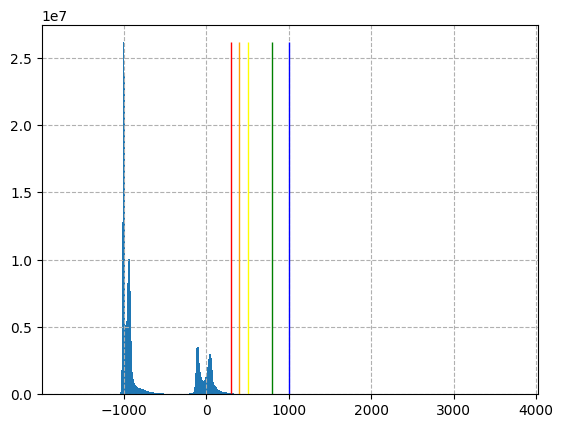

In [68]:
from monai.transforms import Compose, EnsureChannelFirst
loading = Compose([
    LoadImage()
])

whole = []
for idx in tqdm(range(20)):
    data = loading(paths[idx])[0]
    if not idx:
        whole = data.view(-1)
    else:
        whole = torch.cat([whole, data.view(-1)], dim=0)

bins = 1000
# whole = torch.where(whole < -200, 0 , whole)
hist = torch.histc(whole, bins=bins).numpy()
idx = np.argmax(hist)
print(f'{idx=}, {hist[idx]=}')
hist[idx] = -1
# hist = np.where(hist > 0.5 * 1e-6, 0 , hist)
x =np.linspace(np.min(whole), np.max(whole), num=bins) 
plt.grid(linestyle='dashed')
plt.bar(x, hist, align='center', width=20)
plt.vlines(300, 0, np.max(hist), colors='red', linewidth=1)
plt.vlines(400, 0, np.max(hist), colors='orange', linewidth=1)
plt.vlines(500, 0, np.max(hist), colors='yellow', linewidth=1)
plt.vlines(800, 0, np.max(hist), colors='green', linewidth=1)
plt.vlines(1000, 0, np.max(hist), colors='blue', linewidth=1)

plt.show()
    # whole.append(data.view(-1))

# Canceled future for execute_request message before replies were done
# The Kernel crashed while executing code in the the current cell or a previous cell. Please review the code in the cell(s) to identify a possible cause of the failure. Click here for more info. View Jupyter log for further details.

In [1]:

from monai.transforms import ScaleIntensityRange
nrow = 10
ncol = 5
fig, axs = plt.subplots(nrow, ncol, figsize=(20,30))
offset = 0 * nrow * ncol # 원래 99번까지 확인함 
for i, ax in enumerate(fig.axes):
    ax.set_ylabel(str(i+offset))
    
    if i+offset == len(paths):
        break

    for idx in tqdm(range(20), desc=f'{i}'):
        data = loading(paths[idx])[0]
        data = ScaleIntensityRange(a_min=-100, a_max=400, b_min=0, b_max=0, clip=True)(data)
        if not idx:
            whole = data.view(-1)
        else:
            whole = torch.cat([whole, data.view(-1)], dim=0)

    bins = 1000
    whole = torch.where(whole < -200, 0 , whole)
    hist = torch.histc(whole, bins=bins).numpy()
    idx = np.argmax(hist)
    # print(f'{idx=}, {hist[idx]=}')
    hist[idx] = -1
    x =np.linspace(np.min(whole), np.max(whole), num=bins) 
    ax.grid(linestyle='dashed')
    ax.bar(x, hist, align='center', width=0.05) # for CT 20, for PET 0.05
    ax.vlines(300, 0, np.max(hist), colors='red', linewidth=1)
    ax.vlines(400, 0, np.max(hist), colors='orange', linewidth=1)
    ax.vlines(500, 0, np.max(hist), colors='yellow', linewidth=1)
    ax.vlines(800, 0, np.max(hist), colors='green', linewidth=1)
    ax.vlines(1000, 0, np.max(hist), colors='blue', linewidth=1)
    # ax.title("Single Sample distribution")
    # ax.show()
plt.title('x < -200 clip to zero')
plt.show()

NameError: name 'plt' is not defined

100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


idx=3, hist[idx]=167220770.0
-0.24371749 152.62044


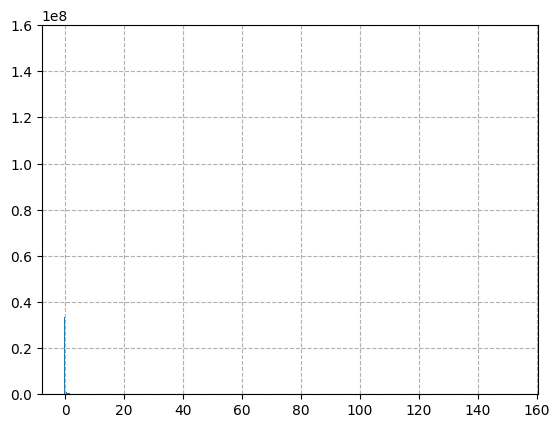

In [65]:
from monai.transforms import Compose, EnsureChannelFirst
loading = Compose([
    LoadImage()
])

whole = []
for idx in tqdm(range(20)):
    data = loading(paths[idx])[0]
    data = NormalizeIntensity()(data)
    if not idx:
        whole = data.view(-1)
    else:
        whole = torch.cat([whole, data.view(-1)], dim=0)

bins = 10000
# whole = torch.where(whole < -200, 0 , whole)
hist = torch.histc(whole, bins=bins).numpy()
idx = np.argmax(hist)
print(f'{idx=}, {hist[idx]=}')
hist[idx] = -1
# hist = np.where(hist > 0.5 * 1e-6, 0 , hist)
x =np.linspace(np.min(whole), np.max(whole), num=bins) 
print(np.min(whole), np.max(whole))
plt.grid(linestyle='dashed')
plt.bar(x, hist, align='center', width=0.05)
# plt.vlines(300, 0, np.max(hist), colors='red', linewidth=1)
# plt.vlines(400, 0, np.max(hist), colors='orange', linewidth=1)
# plt.vlines(500, 0, np.max(hist), colors='yellow', linewidth=1)
# plt.vlines(800, 0, np.max(hist), colors='green', linewidth=1)
# plt.vlines(1000, 0, np.max(hist), colors='blue', linewidth=1)

plt.show()
    # whole.append(data.view(-1))

# Canceled future for execute_request message before replies were done
# The Kernel crashed while executing code in the the current cell or a previous cell. Please review the code in the cell(s) to identify a possible cause of the failure. Click here for more info. View Jupyter log for further details.

1014


49: 100%|██████████| 20/20 [00:18<00:00,  1.05it/s]


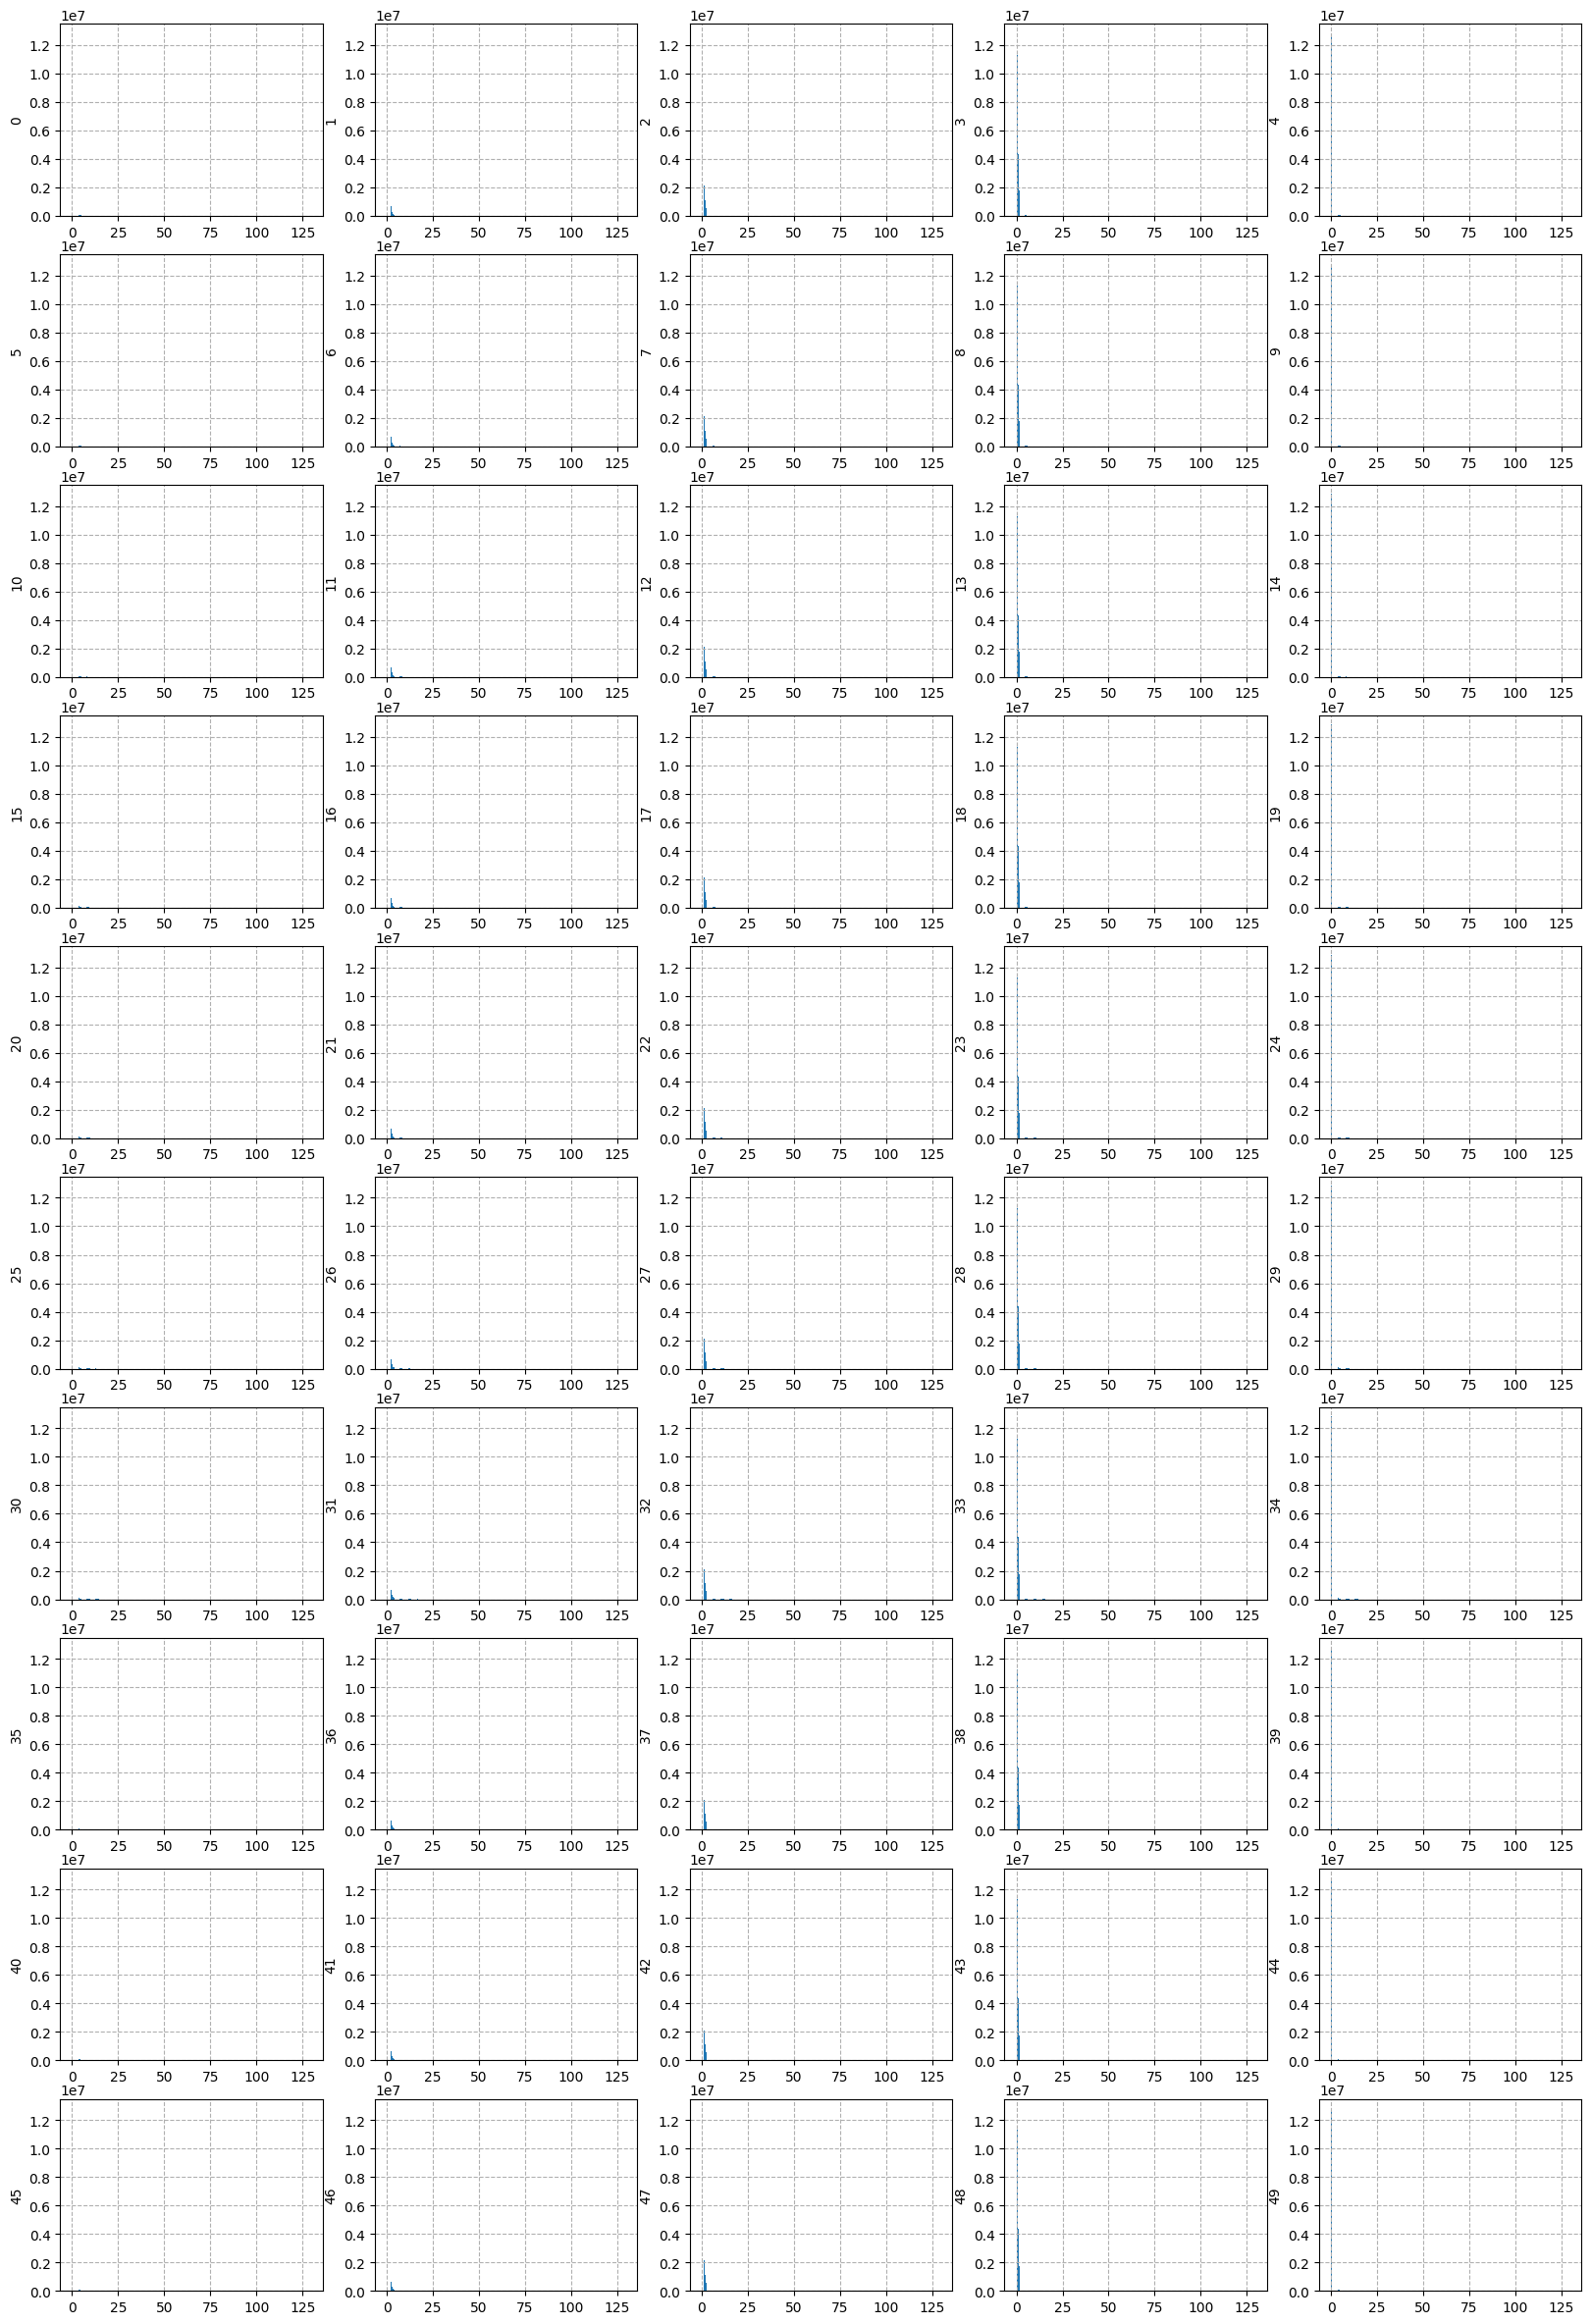

In [55]:
mela_df = df
paths = mela_df.img_path.apply(lambda x: '/'.join([x] + ['SUV.nii.gz'] )).values

print(len(paths))

nrow = 10
ncol = 5
fig, axs = plt.subplots(nrow, ncol, figsize=(20,30))
offset = 0 * nrow * ncol # 원래 99번까지 확인함 
for i, ax in enumerate(fig.axes):
    ax.set_ylabel(str(i+offset))
    
    if i+offset == len(paths):
        break

    for idx in tqdm(range(20), desc=f'{i}'):
        data = loading(paths[idx])[0]


        if not idx:
            whole = data.view(-1)
        else:
            whole = torch.cat([whole, data.view(-1)], dim=0)

    bins = 1000
    hist = torch.histc(whole, bins=bins).numpy()
    idx = np.argmax(hist)
    # print(f'{idx=}, {hist[idx]=}')
    hist[idx] = -1
    x =np.linspace(np.min(whole), np.max(whole), num=bins) 
    ax.grid(linestyle='dashed')
    ax.bar(x, hist, align='center', width=0.05) # for CT 20, for PET 0.05
    # ax.title("Single Sample distribution")
    # ax.show()
plt.show()

1014


49: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


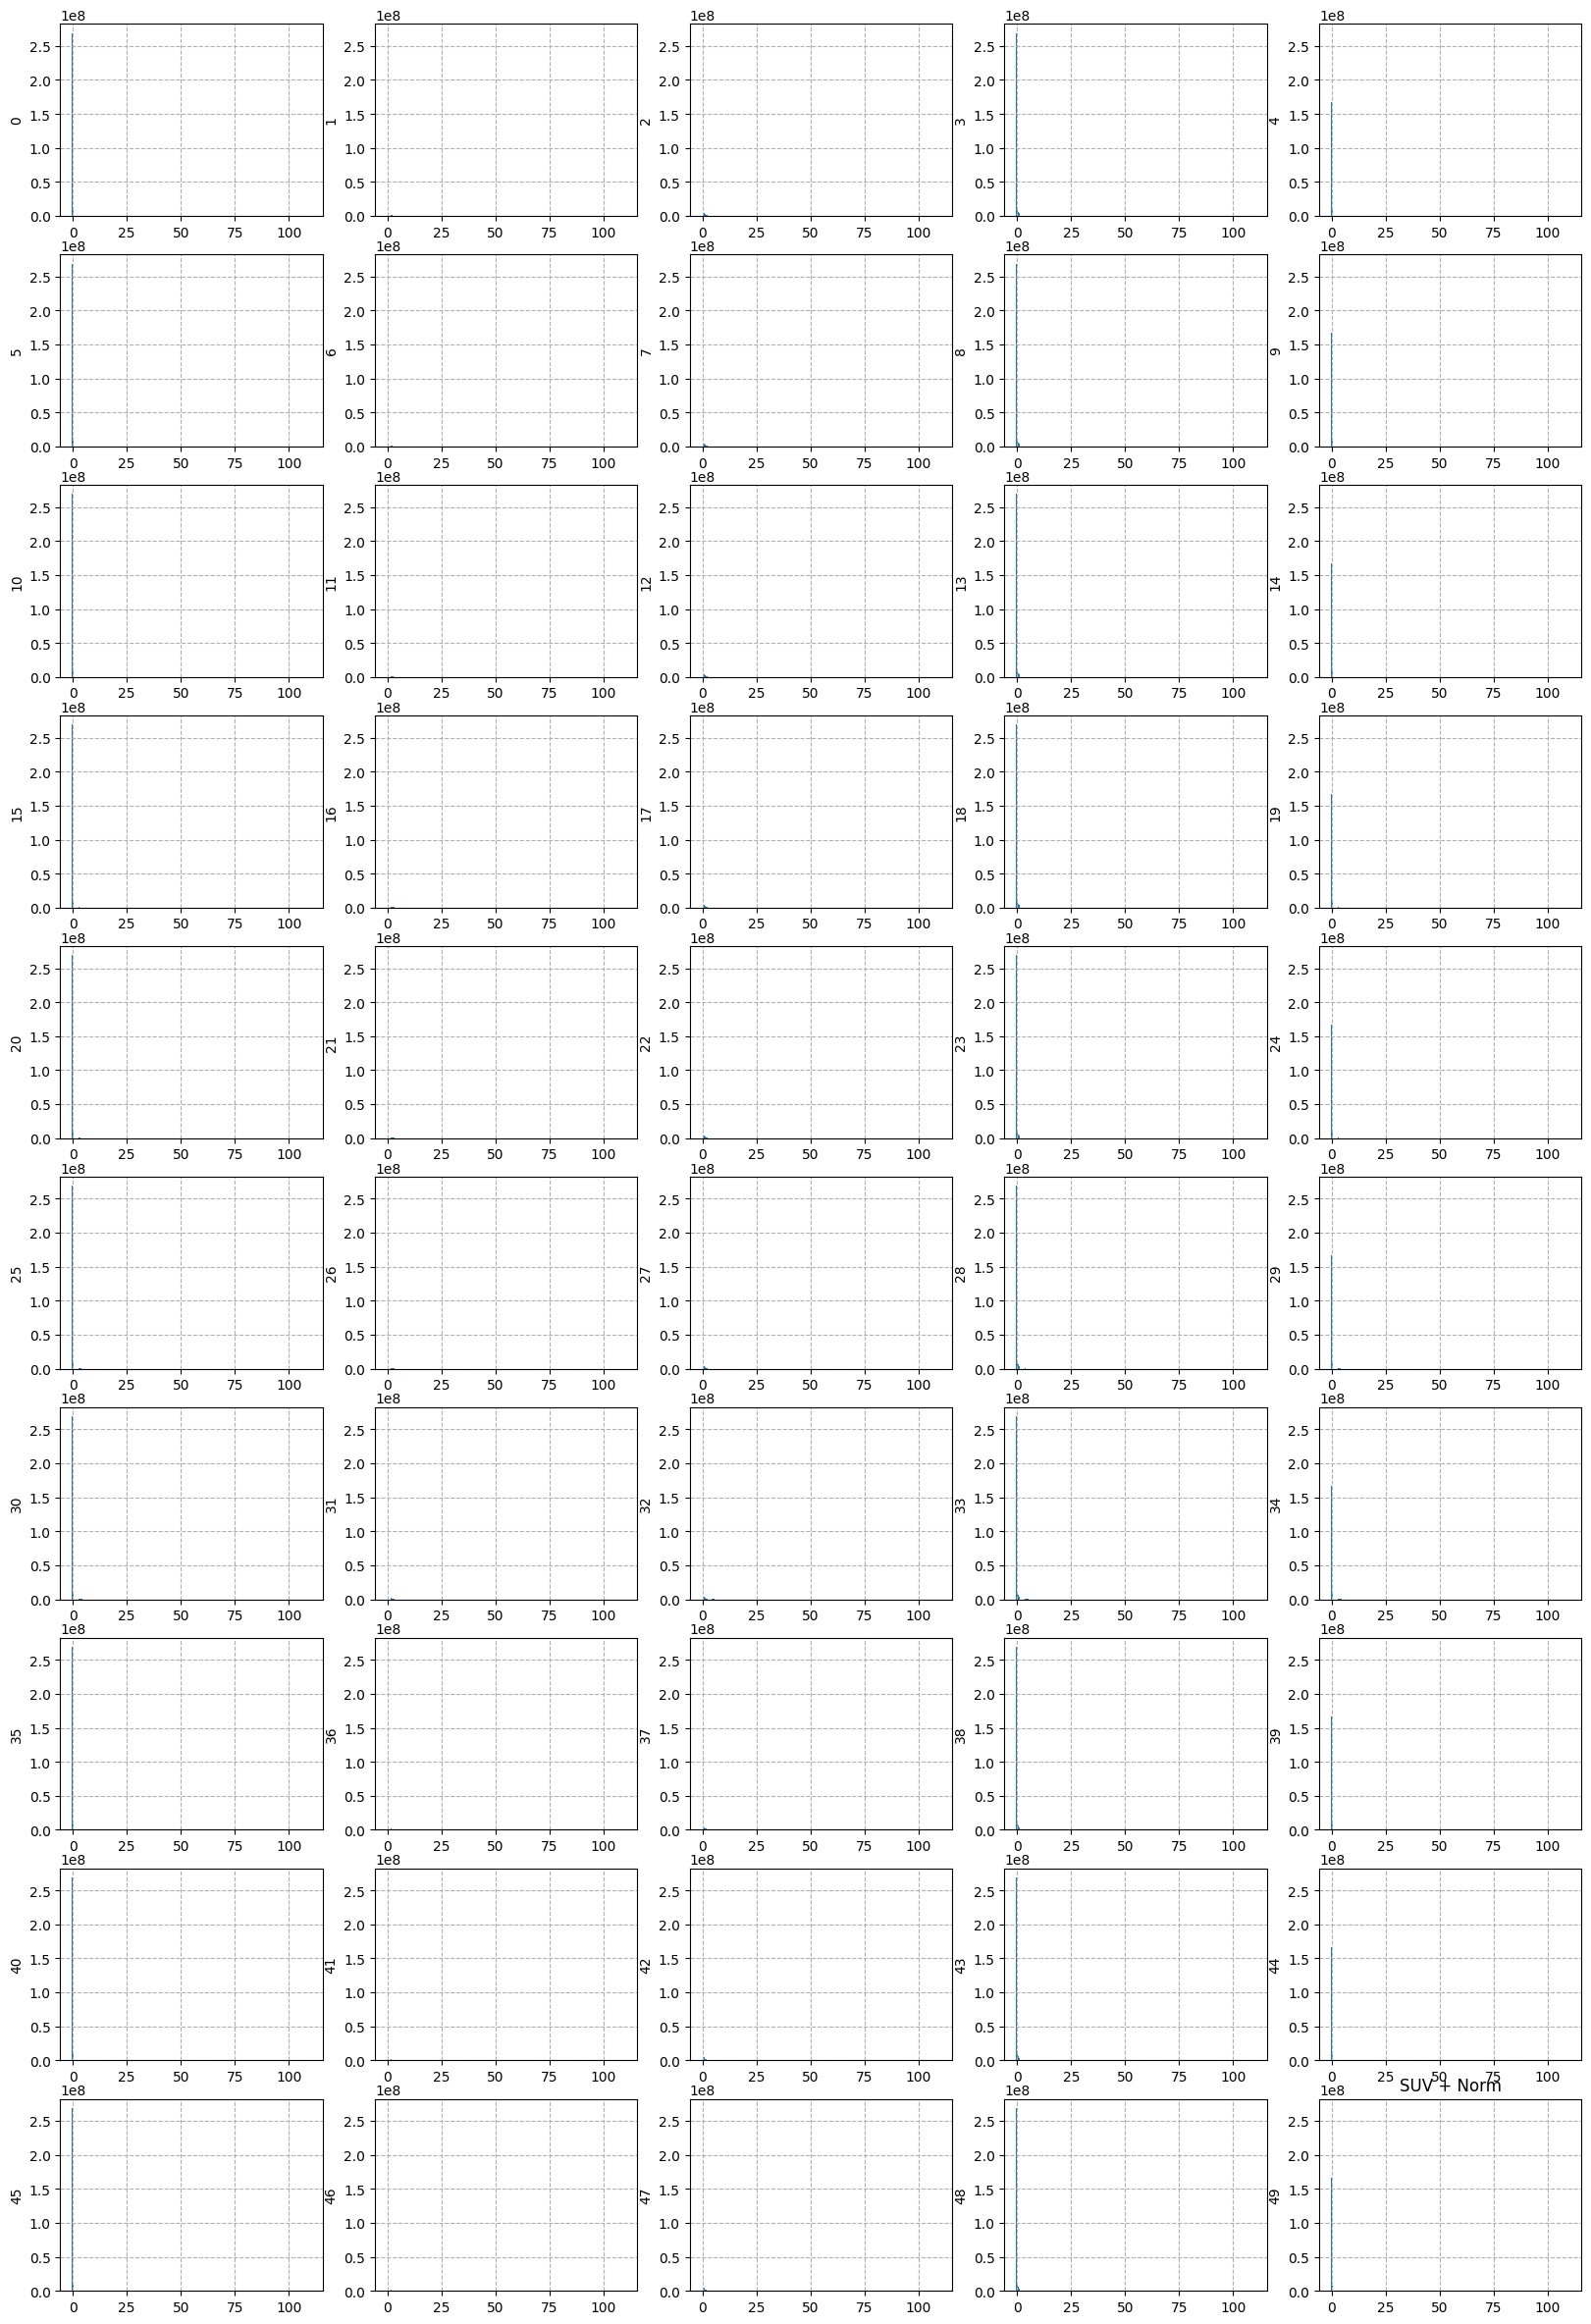

In [56]:
from monai.transforms import NormalizeIntensity
mela_df = df
paths = mela_df.img_path.apply(lambda x: '/'.join([x] + ['SUV.nii.gz'] )).values

print(len(paths))

nrow = 10
ncol = 5
fig, axs = plt.subplots(nrow, ncol, figsize=(20,30))
offset = 0 * nrow * ncol # 원래 99번까지 확인함 
for i, ax in enumerate(fig.axes):
    ax.set_ylabel(str(i+offset))
    
    if i+offset == len(paths):
        break

    for idx in tqdm(range(20), desc=f'{i}'):
        data = loading(paths[idx])[0]
        data = NormalizeIntensity()(data)



        if not idx:
            whole = data.view(-1)
        else:
            whole = torch.cat([whole, data.view(-1)], dim=0)

    bins = 1000
    hist = torch.histc(whole, bins=bins).numpy()
    idx = np.argmax(hist)
    # print(f'{idx=}, {hist[idx]=}')
    hist[idx] = -1
    x =np.linspace(np.min(whole), np.max(whole), num=bins) 
    ax.grid(linestyle='dashed')
    ax.bar(x, hist, align='center', width=0.05) # for CT 20, for PET 0.05
    # ax.title("Single Sample distribution")
    # ax.show()
plt.title('SUV + Norm')
plt.show()

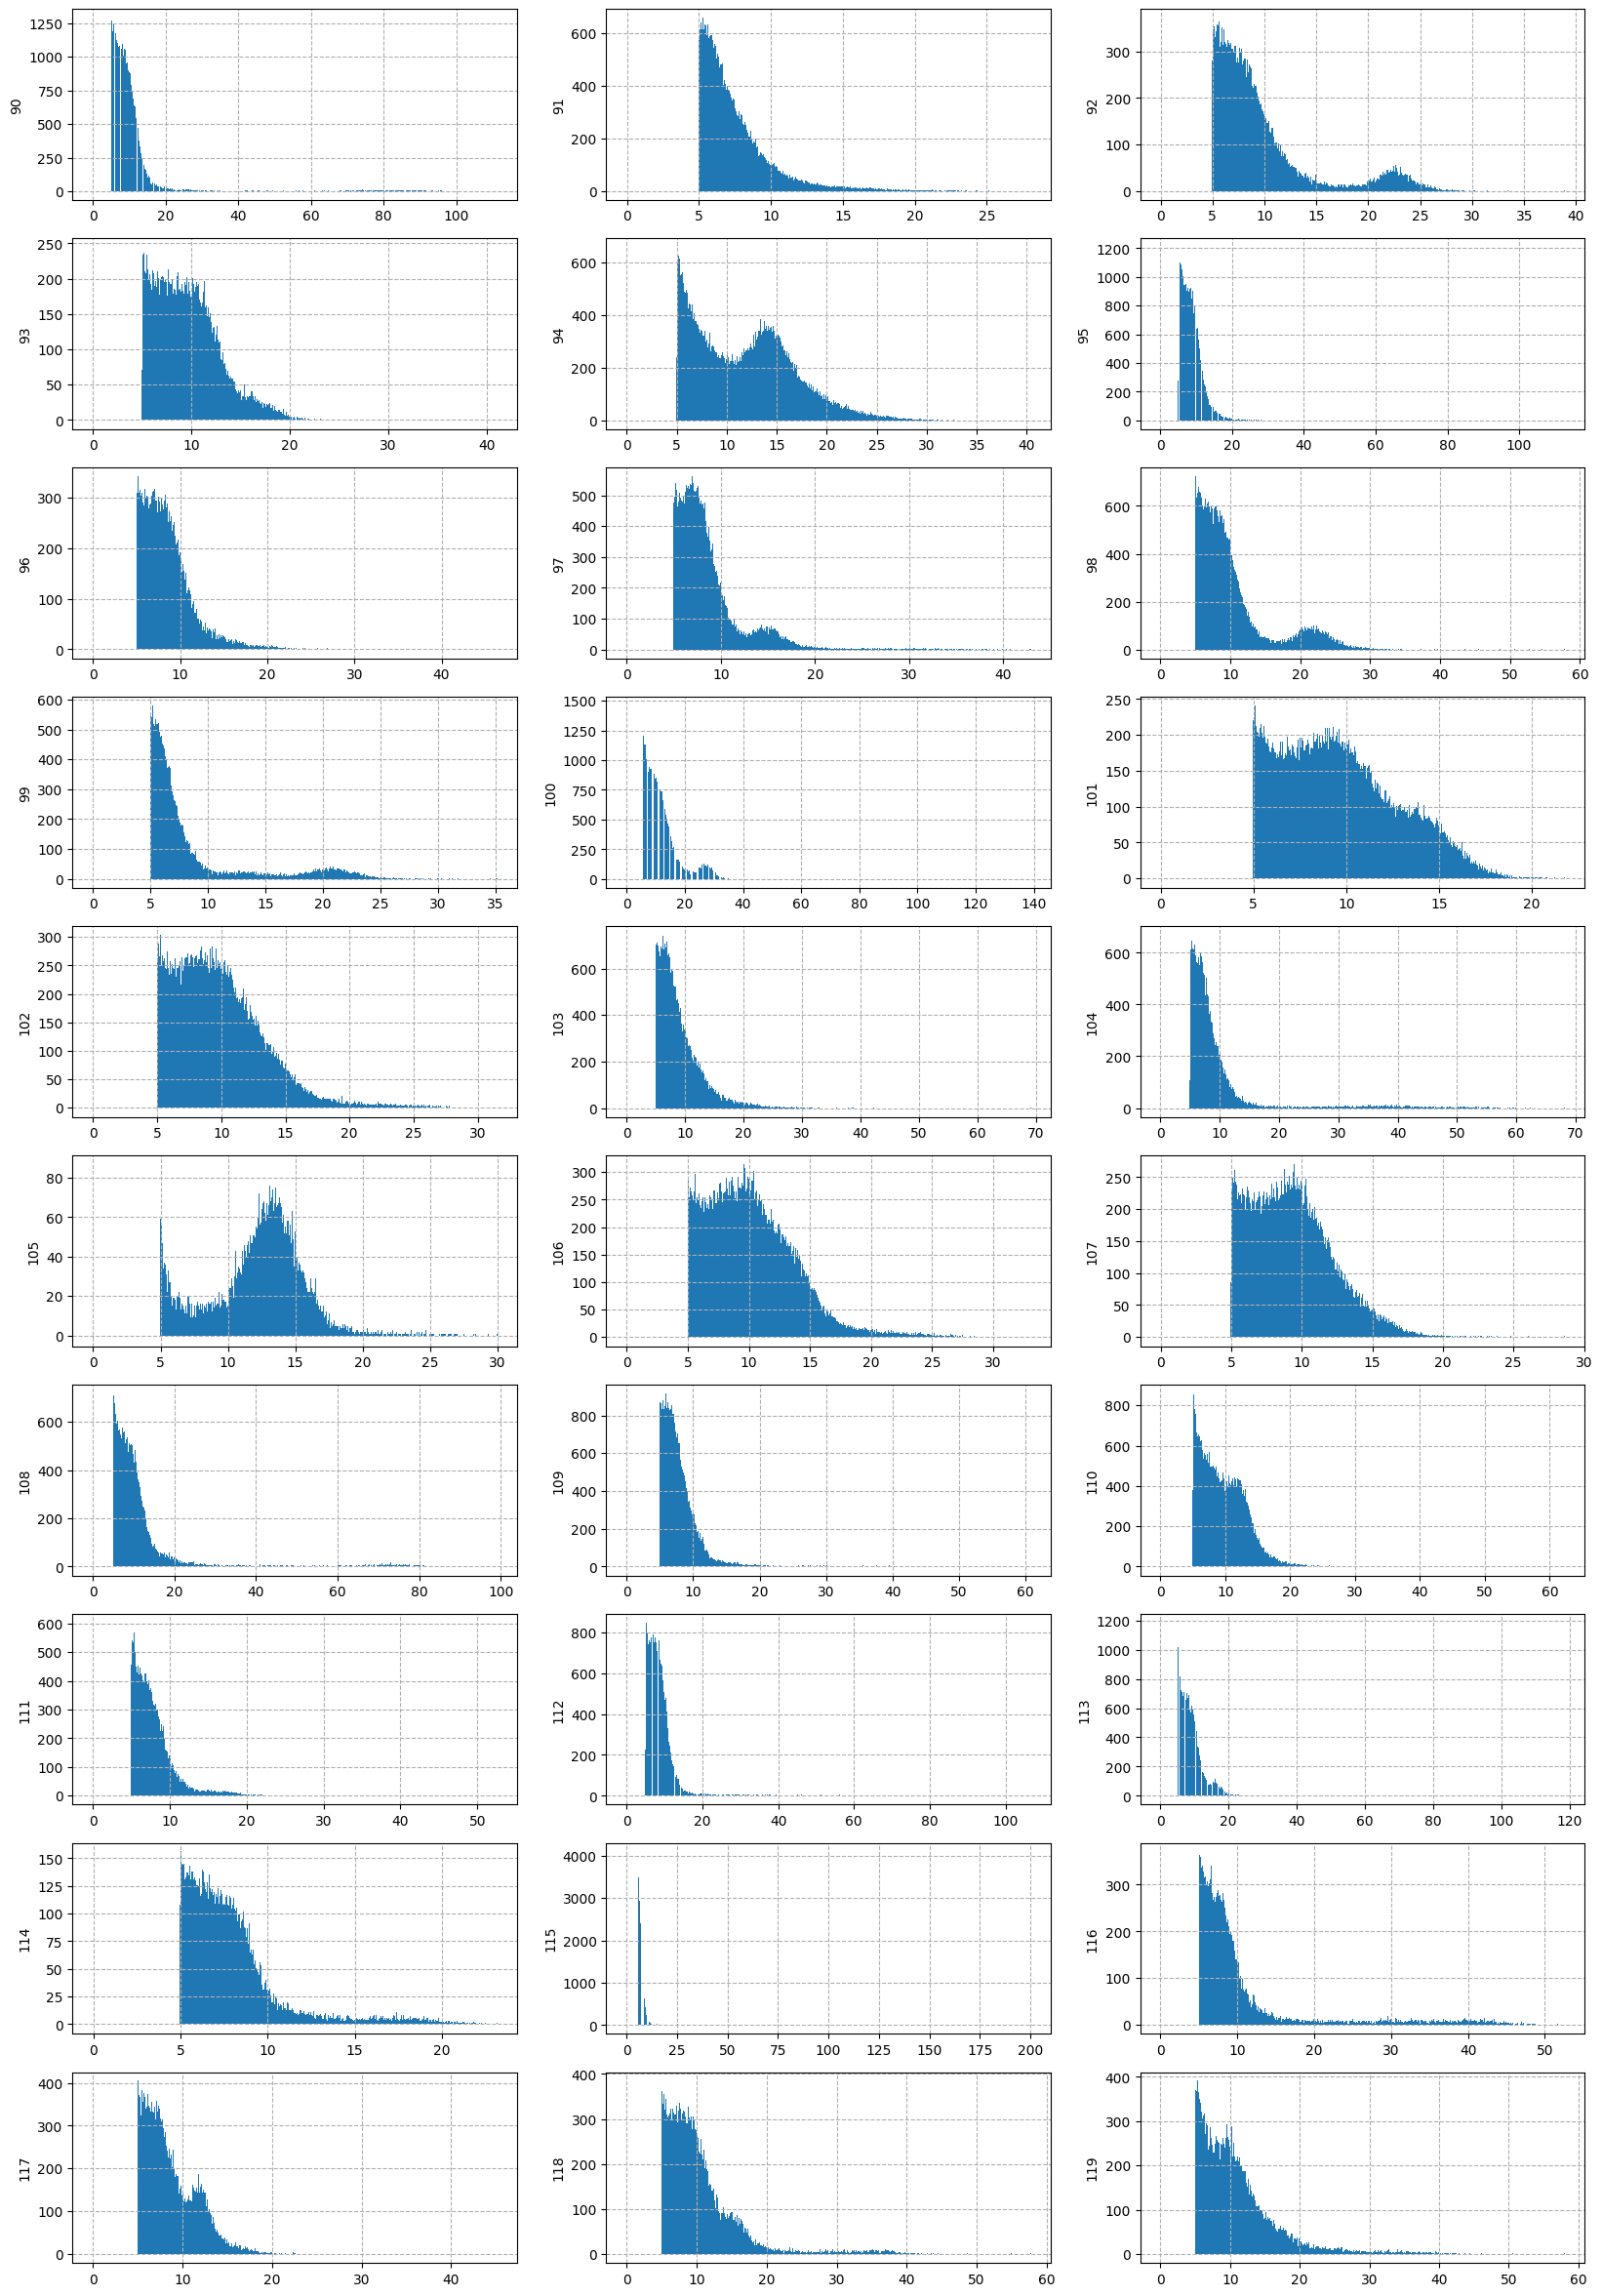

In [56]:
# 57, 60 SUV 이상함 
## Single Sample 
nrow = 10
ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize=(20,30))
offset = 3 * nrow * ncol # 원래 99번까지 확인함 
for i, ax in enumerate(fig.axes):
    ax.set_ylabel(str(i+offset))
    
    if i+offset == len(paths):
        break
    data = LoadImage()(paths[i+offset])[0]


    bins = 2000
    data = torch.where(data <5, 0, data)
    hist = torch.histc(data, bins=bins).numpy()
    idx = np.argmax(hist)
    hist[idx] = -1 
    min_val = np.min(data)
    max_val = np.max(data)
    if max_val > 5000.:
        print(f'[{i}], argmax()={idx}, {hist[idx]=}, min:{min_val}, max:{max_val}')
        print(paths[i+offset])
    hist[idx] = -1
    x = np.linspace(min_val, max_val, num=bins)
    ax.grid(linestyle='dashed')
    ax.bar(x, hist, align='center', width=0.05)
    # ax.title("Single Sample distribution")
    # ax.show()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

train, val, *_ = train_test_split(df, df['diagnosis'], test_size=0.3, stratify=df['diagnosis'], random_state=41)

In [ ]:

print('__Train__')
print(f'{pd.concat([train.diagnosis.value_counts(normalize=True), train.diagnosis.value_counts()], axis=1, keys=["%","|x|"])}')

print('\n')
print('__Validation__')
print(f'{pd.concat([val.diagnosis.value_counts(normalize=True), val.diagnosis.value_counts()], axis=1, keys=["%","|x|"])}')

__Train__
                  %   |x|
diagnosis                
3          0.505871  1077
2          0.185533   395
0          0.165806   353
1          0.142790   304


__Validation__
                  %  |x|
diagnosis               
3          0.506024  462
2          0.185104  169
0          0.165389  151
1          0.143483  131


# Compose group Test

In [23]:
from monai.transforms import (
                            Compose,
                            EnsureChannelFirstd,
                            EnsureTyped,
                            ScaleIntensityRangePercentilesD,
                            Orientationd,
                            # CropForegroundd, 
                            OneOf,
                            RandCropByPosNegLabeld,
                            RandSpatialCropd,
                            RandFlipd,
                            RandShiftIntensityd,
                        )

all_key = ['ct','pet','label']

test_transform = Compose([
    LoadImaged(keys=all_key, ensure_channel_first=True),
    EnsureTyped(keys=all_key, track_meta=True),
    Orientationd(keys=all_key, axcodes='RAS'),
    ScaleIntensityRangePercentilesD(keys='ct',
                                    lower=1, upper=99,
                                    b_min=0, b_max=1, clip=True)]
)

train_transform = [
    Compose([
        LoadImaged(keys=all_key, ensure_channel_first=True),
        EnsureTyped(keys=all_key, track_meta=True), # for training track_meta=False, monai.data.set_track_meta(false)
        Orientationd(keys=all_key, axcodes='RAS'),
        ScaleIntensityRangePercentilesD(keys='ct',
                                        lower=1, upper=99,
                                        b_min=0, b_max=1, clip=True),
        # CropForegroundd(keys=all_key, source_key='pet') # source_key 'ct' or 'pet'
        OneOf([
        RandCropByPosNegLabeld(keys=all_key, label_key='label', spatial_size=(128,128,128), pos=1, neg=0.5, num_samples=1), # 흑색종일때 label에 따라서 잘 되는지 확인해야함 
        RandSpatialCropd(keys=all_key, roi_size=[128,128,128], random_size=False),
        ]),

        RandFlipd(keys=all_key, prob=0.5, spatial_axis=0),
        RandFlipd(keys=all_key, prob=0.5, spatial_axis=1),
        RandFlipd(keys=all_key, prob=0.5, spatial_axis=2),
    ]
    ),
    Compose([
        LoadImaged(keys=all_key, ensure_channel_first=True),
        EnsureTyped(keys=all_key, track_meta=True), # for training track_meta=False, monai.data.set_track_meta(false)
        Orientationd(keys=all_key, axcodes='RAS'),
        ScaleIntensityRangePercentilesD(keys='ct',
                                        lower=1, upper=99,
                                        b_min=0, b_max=1, clip=True),
        # CropForegroundd(keys=all_key, source_key='pet') # source_key 'ct' or 'pet'
        RandSpatialCropd(keys=all_key, roi_size=[128,128,128], random_size=False),

        RandFlipd(keys=all_key, prob=0.5, spatial_axis=0),
        RandFlipd(keys=all_key, prob=0.5, spatial_axis=1),
        RandFlipd(keys=all_key, prob=0.5, spatial_axis=2),
    ]
    )
]

for_train = train_transform[0](path_d)
for_test = test_transform(path_d)


In [24]:
not None

True

In [25]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class PETCT_dataset(Dataset):
    def __init__(self, image_path=None, diagnosis=None,  transform=None, negative_val=None) -> None:
        super().__init__()
        self.image_path = image_path
        self.diagnosis = diagnosis
        self.transform = transform
        self.negative_val = negative_val[0] if negative_val else negative_val

    def __getitem__(self, index):
        return self.get_SCANS(self.image_path[index], self.diagnosis[index])

    def __len__(self):
        return len(self.image_path)
    
    def get_SCANS(self, path, diagnosis):
        
        ctres = f'{path}/CTres.nii.gz'
        suv = f'{path}/SUV.nii.gz'
        seg = f'{path}/SEG.nii.gz'

        path_d = {
            'ct': ctres,
            'pet': suv,
            'label': seg,
            'diagnosis': diagnosis
        }

        # data_d = LoadImaged(keys=['ct','pet','label'], ensure_channel_first=True)(path_d)

        data_d = self.transform[0](path_d) if diagnosis != self.negative_val and not self.negative_val else self.transform[1](path_d)

        if isinstance(data_d, list):
            data_d = data_d[0]
        
        return data_d

In [26]:
from sklearn.model_selection import StratifiedKFold

meta_df = pd.read_csv('/root/Competitions/MICCAI/AutoPET2023/data/Metadata-FDG_PET_CT.csv')
meta_df = meta_df[meta_df['SOP Class Name'] == 'Segmentation Storage'] # to remove the redundancy path
file_paths = meta_df['File Location'].apply(lambda x: '/'.join([data_dir] + x.split('/')[2:4])) # Even faster 

df = pd.DataFrame(columns=['img_path', 'diagnosis'])
df['img_path'] = file_paths
df['diagnosis'] = meta_df.diagnosis

for idx in range(len(meta_df)): assert df.iloc[idx].diagnosis== meta_df.iloc[idx].diagnosis

le = preprocessing.LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'])
NEGATIVE_VAL = le.transform(['NEGATIVE'])

kf = StratifiedKFold(n_splits=5,
            shuffle=True,
            random_state=42)

all_splits = [k for k in kf.split(df, df['diagnosis'])]
train_idx, val_idx = all_splits[1]
train_idx, val_idx = train_idx.tolist(), val_idx.tolist()

train = df.iloc[train_idx]
val = df.iloc[val_idx]
num_cls = len(le.classes_)

train_data = PETCT_dataset(train['img_path'].values, train['diagnosis'].values, train_transform, NEGATIVE_VAL)
val_data = PETCT_dataset(val['img_path'].values, val['diagnosis'].values, [test_transform])

train_loader = DataLoader(train_data, 2, shuffle=True, drop_last=True)
test_loader = DataLoader(val_data, 1, shuffle=False )

In [27]:
le.transform(['NEGATIVE'])

array([3])

In [28]:
print("train_loader check")
for idx, batch in enumerate(train_loader):
    print(f'{idx}] okay, {batch["ct"].shape}, {batch["pet"].shape}, {batch["label"].shape}, {batch["diagnosis"]}')
    print(f'\t {torch.unique(batch["ct"])}, {torch.unique(batch["pet"])}, {torch.unique(batch["label"])}')
    if idx == 10: break


print("train_loader check")
for idx, batch in enumerate(test_loader):
    print(f'{idx}] okay, {batch["ct"].shape}, {batch["pet"].shape}, {batch["label"].shape}, {batch["diagnosis"]}')
    print(f'\t {torch.unique(batch["ct"])}, {torch.unique(batch["pet"])}, {torch.unique(batch["label"])}')
    if idx == 10: break

train_loader check
0] okay, torch.Size([2, 1, 128, 128, 128]), torch.Size([2, 1, 128, 128, 128]), torch.Size([2, 1, 128, 128, 128]), tensor([3, 2])
	 tensor([0.0000e+00, 5.2678e-08, 5.5966e-08,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00]), tensor([0.0000e+00, 4.6562e-05, 4.7779e-05,  ..., 3.5434e+01, 3.8763e+01,
        3.9367e+01]), tensor([0., 1.])
1] okay, torch.Size([2, 1, 128, 128, 128]), torch.Size([2, 1, 128, 128, 128]), torch.Size([2, 1, 128, 128, 128]), tensor([3, 3])
	 tensor([0.0000e+00, 5.3151e-08, 1.0630e-07,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00]), tensor([0.0000e+00, 3.8461e-05, 3.9849e-05,  ..., 1.2346e+01, 1.2513e+01,
        1.3233e+01]), tensor([0.])
2] okay, torch.Size([2, 1, 128, 128, 128]), torch.Size([2, 1, 128, 128, 128]), torch.Size([2, 1, 128, 128, 128]), tensor([2, 2])
	 tensor([0.0000e+00, 5.1573e-08, 5.3486e-08,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00]), tensor([0.0000e+00, 4.0429e-05, 4.4912e-05,  ..., 3.3338e+01, 3.4060e+01,
    

# Metric Applying Test

In [ ]:
## Metric operation Test
import torch 
from monai.metrics import DiceMetric, ConfusionMatrixMetric
from monai.transforms import (
                        Activations,
                        Compose,
                        AsDiscrete,
                        EnsureChannelFirstd
                    )
data_d = EnsureChannelFirstd(keys=['image','label'])(data_d)

In [ ]:
dice_M = DiceMetric()
confusion_M = ConfusionMatrixMetric()  # ["miss_rate", "false_negative_rate", "fnr"] ["fall_out", "false_positive_rate", "fpr"]:

GT = torch.ones((1,1,1,3,3))
PRED = torch.rand((1,1,1,3,3))
converter = Compose(
    AsDiscrete(threshold=0.5)
)
print(PRED)
PRED = converter(PRED)
print(PRED)

PRED[0,0,0,0,0] = 0 
print(PRED)


# assert len(y.shape) == 5 and y.shape == y_pred.shape, 'for using DiceMetric func of monai, input tensors sholud be [B,C,H,W,(D)]'
dice_score = dice_M(y_pred=[PRED,PRED], y=[GT,GT]) # y_pred should be a binarized tensor.
print(dice_score)
# print(f'{dice_score.item()=}')

confusion_ret = confusion_M(y_pred=[PRED,PRED], y=[GT,GT])
tp, fp, tn, fn = confusion_ret[..., 0], confusion_ret[..., 1], confusion_ret[..., 2], confusion_ret[..., 3]
print(tp,fp,tn,fn)
print(f'False positive {fp}, False Negative {fn}')

print(f'False Positive Rate {fp / (fp+tn +1e-8)}')
print(f'False Negative Rate {fn / (fn+tp +1e-8)}')
# tensor([[[ 1.2990e+03, -4.0000e+00,  5.2159e+07,  0.0000e+00]]])

tensor([[[[[0.0910, 0.5809, 0.6075],
           [0.0174, 0.7982, 0.3734],
           [0.4459, 0.1106, 0.7088]]]]])
tensor([[[[[0., 1., 1.],
           [0., 1., 0.],
           [0., 0., 1.]]]]])
tensor([[[[[0., 1., 1.],
           [0., 1., 0.],
           [0., 0., 1.]]]]])
tensor([[0.6154],
        [0.6154]])
tensor([[4.],
        [4.]]) tensor([[0.],
        [0.]]) tensor([[0.],
        [0.]]) tensor([[5.],
        [5.]])
False positive tensor([[0.],
        [0.]]), False Negative tensor([[5.],
        [5.]])
False Positive Rate tensor([[0.],
        [0.]])
False Negative Rate tensor([[0.5556],
        [0.5556]])


In [ ]:
print(y.shape)
print(y.unsqueeze(0).shape)

torch.Size([1, 400, 400, 326])
torch.Size([1, 1, 400, 400, 326])


In [ ]:
y_pred = y = y.unsqueeze(0)
y = y.float()
y_pred = y_pred.float()

if y.shape != y_pred.shape:
    raise ValueError(f"y_pred and y should have same shapes, got {y_pred.shape} and {y.shape}.")

# reducing only spatial dimensions (not batch nor channels)
n_len = len(y_pred.shape)
reduce_axis = list(range(2, n_len))
print(reduce_axis)
intersection = torch.sum(y * y_pred, dim=reduce_axis)

y_o = torch.sum(y, reduce_axis)
y_pred_o = torch.sum(y_pred, dim=reduce_axis)
denominator = y_o + y_pred_o

torch.where(denominator > 0, (2.0 * intersection) / denominator, torch.tensor(1.0, device=y_o.device))

[2, 3, 4]


tensor([[1.]])